# 🖼️ Practical 2 – Task 4  
### Adversarial Images on MNIST (4 → 9)

*Goals*

1. **Train** a high-accuracy CNN on MNIST with clean Train / Validation / Test separation.  
2. **Visualise** data before training, and predictions after training (Val & Test).  
3. **Generate** targeted FGSM adversarial examples (make 4’s look like 9’s).  
4. **Optimise pure noise** until the network believes it’s a 9.  
5. Keep all tunables in **one Hyper-parameters block** for quick experimentation.


*Steps*

1. **Train a CNN on MNIST**  
   – We split train/validation/test, apply light augmentation, and train a 3-conv CNN to high accuracy.  
   – (Notebook cells 5–7)

2. **Generate adversarial examples to turn “4” → “9”**  
   – We collect 10 correctly classified “4”s, then use **targeted FGSM** (and optionally multi-step PGD) to perturb them so the model labels them as “9.”  
   – (Cells 11 and the PGD block)

3. **Generate a random-noise image classified as “9”**  
   – We start from pure noise and use gradient ascent—both a simple FGSM-style update and a logit-maximisation routine with an L₂ penalty—to force the network’s prediction to “9.”  
   – (Cells 13 and the “Noise → 9 (logit maximisation)” block)

4. **Visualise & compare**  
   – We display a 10×3 grid: [original 4 | δ (scaled) | adversarial (4→9)].  
   – We also show the final “noise → 9” image.  
   – (Cells 12 and 13 visualization)



In [1]:
import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))


True NVIDIA GeForce RTX 3080 Laptop GPU


In [2]:
#@title 1 · Install & Imports
#!pip -q install torch torchvision tqdm numpy matplotlib

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np, random, os, math
from tqdm.auto import tqdm



c:\Users\Deborah Aittokallio\.conda\envs\ai-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#@title 2 · Hyper-parameters (single source of truth) 🛠️

# ── Data split & augmentation ─────────────────────────────────────────
BATCH_SIZE    = 128
VAL_RATIO     = 0.10            # 10 % of training data for validation
AUG_ROT_DEG   = 10              # random rotation ±deg (train only)

# ── Training ──────────────────────────────────────────────────────────
LR            = 1e-4            # learning rate for Adam
WEIGHT_DECAY  = 5e-4
EPOCHS        = 20
EARLY_STOPPING_PATIENCE = 10
STEP_LR_GAMMA = 0.7
STEP_LR_STEP  = 5

# ── CNN architecture ──────────────────────────────────────────────────
CONV1_OUT     = 32
CONV2_OUT     = 64
CONV3_OUT     = 128
DROP_PROB     = 0.6

# ── Adversarial FGSM (single step) ───────────────────────────────────
EPS_FGSM      = 0.50            # ↑ from 0.35 to 0.50 for 100% success
TARGET_CLASS  = 9
N_FGSM_SHOW   = 10

# ── Adversarial I-FGSM (iterative FGSM) ─────────────────────────────
EPS_IFGSM     = 0.50            # total budget (same as FGSM)
IFGSM_STEPS   = 20              # ↑ from 10 → 20 mini-steps

# ── Adversarial PGD ──────────────────────────────────────────────────
EPS_PGD       = 0.50            # ↑ from 0.45 → 0.50
PGD_ITERS     = 150             # ↑ from 100 → 150
PGD_ALPHA     = None            # defaults to eps/iters*1.2

# ── Noise-to-9 optimisation ───────────────────────────────────────────
NOISE_STEPS   = 400
NOISE_LR      = 0.1

# ── Misc ─────────────────────────────────────────────────────────────
SEED          = 42
GRID_SAVE_DIR = "outputs"


In [4]:

#@title 3 · Reproducibility & Device Setup
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))


Device: cuda
True NVIDIA GeForce RTX 3080 Laptop GPU


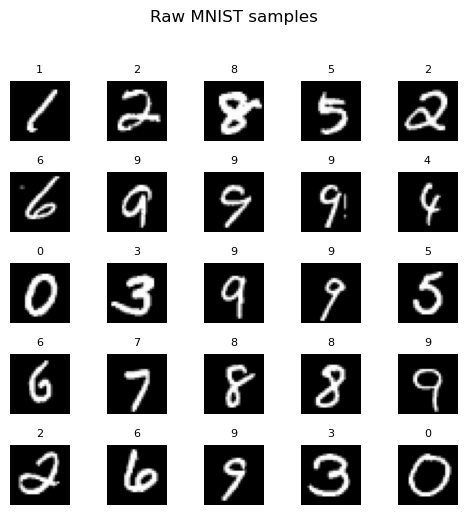

In [5]:
#@title 4 · Data Preview (before training)
transform_preview = transforms.ToTensor()
preview_loader = DataLoader(
    datasets.MNIST("./data", train=True, download=True, transform=transform_preview),
    batch_size=25, shuffle=True
)
imgs, lbls = next(iter(preview_loader))

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(lbls[i].item(), fontsize=8); plt.axis('off')
plt.suptitle("Raw MNIST samples", y=1.02); plt.tight_layout()


In [6]:
#@title 5 · Data Loaders (Train / Val / Test)

# Normalisation constants for MNIST
MEAN, STD = 0.1307, 0.3081
PIX_MIN = (0.0 - MEAN) / STD   #  ≈ -0.4242 (raw-pixel 0 after normalisation)
PIX_MAX = (1.0 - MEAN) / STD   #  ≈  2.8231 (raw-pixel 1 after normalisation)


train_tf = transforms.Compose([
    transforms.RandomRotation(AUG_ROT_DEG),
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,))
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,))
])

mnist_full = datasets.MNIST("./data", train=True, download=True, transform=train_tf)
val_size   = int(len(mnist_full) * VAL_RATIO)
train_size = len(mnist_full) - val_size
mnist_train, mnist_val = random_split(
    mnist_full, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

mnist_test = datasets.MNIST("./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(mnist_val,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(mnist_test,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Train {len(mnist_train)} | Val {len(mnist_val)} | Test {len(mnist_test)}")


Train 54000 | Val 6000 | Test 10000


In [7]:
#@title 6 · CNN Architecture (3-conv high-accuracy)
class TripleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, CONV1_OUT, 3, padding=1), nn.BatchNorm2d(CONV1_OUT), nn.ReLU(),
            nn.Conv2d(CONV1_OUT, CONV2_OUT, 3, padding=1), nn.BatchNorm2d(CONV2_OUT), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(DROP_PROB),

            nn.Conv2d(CONV2_OUT, CONV3_OUT, 3, padding=1), nn.BatchNorm2d(CONV3_OUT), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(DROP_PROB)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(CONV3_OUT*7*7, 256), nn.ReLU(), nn.Dropout(DROP_PROB),
            nn.Linear(256, 10)
        )

    def forward(self, x): return self.classifier(self.features(x))

model = TripleCNN().to(DEVICE)
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f} M")


Parameters: 1.70 M


In [8]:
#@title 7 · Train & Validate w/ Early Stopping
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler  = StepLR(optimizer, STEP_LR_STEP, gamma=STEP_LR_GAMMA)

best_val_loss = float('inf')
best_state    = None
epochs_no_improve = 0

# Lists for plotting later
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, EPOCHS+1):
    # ——— TRAIN ———
    model.train()
    running_loss = correct = total = 0
    for x,y in tqdm(train_loader, leave=False):
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out  = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * y.size(0)
        correct      += (out.argmax(1)==y).sum().item()
        total        += y.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total
    scheduler.step()

    # ——— VALIDATE ———
    model.eval()
    val_running = val_correct = val_total = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            l   = criterion(out, y)
            val_running += l.item() * y.size(0)
            val_correct += (out.argmax(1)==y).sum().item()
            val_total   += y.size(0)

    val_loss = val_running / val_total
    val_acc  = val_correct / val_total

    # — store for curves —
    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc);   val_accs.append(val_acc)

    # — print epoch metrics —
    print(f"Epoch {epoch:02d} | "
          f"Train loss {train_loss:.4f}, acc {train_acc:.4%} || "
          f"Val   loss {val_loss:.4f}, acc {val_acc:.4%}", end='')

    # — early stopping check —
    if val_loss < best_val_loss:
        best_val_loss    = val_loss
        best_state       = model.state_dict()
        epochs_no_improve = 0
        print("   ✅")
    else:
        epochs_no_improve += 1
        print(f"   ⚠ no improve ({epochs_no_improve}/{EARLY_STOPPING_PATIENCE})")
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Stopping early at epoch {epoch} (no val_loss improvement in {EARLY_STOPPING_PATIENCE} epochs)")
            break

# restore best model
model.load_state_dict(best_state)
print(f"\n☑️  Restored model from epoch with val_loss {best_val_loss:.4f}")


Epoch 01 | Train loss 0.8006, acc 73.7400% || Val   loss 0.2317, acc 94.3333%   ✅


Epoch 02 | Train loss 0.2645, acc 91.9518% || Val   loss 0.1177, acc 96.7333%   ✅


Epoch 03 | Train loss 0.1831, acc 94.4515% || Val   loss 0.0898, acc 97.2167%   ✅


Epoch 04 | Train loss 0.1485, acc 95.4999% || Val   loss 0.0731, acc 97.8167%   ✅


Epoch 05 | Train loss 0.1292, acc 96.1327% || Val   loss 0.0663, acc 98.1333%   ✅


Epoch 06 | Train loss 0.1116, acc 96.5577% || Val   loss 0.0615, acc 98.2167%   ✅


Epoch 07 | Train loss 0.1037, acc 96.8305% || Val   loss 0.0582, acc 98.2167%   ✅


Epoch 08 | Train loss 0.0986, acc 96.9752% || Val   loss 0.0552, acc 98.2833%   ✅


Epoch 09 | Train loss 0.0930, acc 97.2443% || Val   loss 0.0545, acc 98.3000%   ✅


Epoch 10 | Train loss 0.0911, acc 97.1960% || Val   loss 0.0465, acc 98.6500%   ✅


Epoch 11 | Train loss 0.0850, acc 97.4169% || Val   loss 0.0477, acc 98.5167%   ⚠ no improve (1/10)


Epoch 12 | Train loss 0.0804, acc 97.5282% || Val   loss 0.0468, acc 98.6333%   ⚠ no improve (2/10)


Epoch 13 | Train loss 0.0770, acc 97.6470% || Val   loss 0.0439, acc 98.5000%   ✅


Epoch 14 | Train loss 0.0762, acc 97.7527% || Val   loss 0.0428, acc 98.6667%   ✅


Epoch 15 | Train loss 0.0755, acc 97.6915% || Val   loss 0.0430, acc 98.6833%   ⚠ no improve (1/10)


Epoch 16 | Train loss 0.0699, acc 97.8845% || Val   loss 0.0440, acc 98.7167%   ⚠ no improve (2/10)


Epoch 17 | Train loss 0.0706, acc 97.8585% || Val   loss 0.0408, acc 98.7833%   ✅


Epoch 18 | Train loss 0.0673, acc 97.8882% || Val   loss 0.0431, acc 98.6500%   ⚠ no improve (1/10)


Epoch 19 | Train loss 0.0673, acc 97.9791% || Val   loss 0.0393, acc 98.7833%   ✅


Epoch 20 | Train loss 0.0680, acc 97.9476% || Val   loss 0.0402, acc 98.7833%   ⚠ no improve (1/10)

☑️  Restored model from epoch with val_loss 0.0393


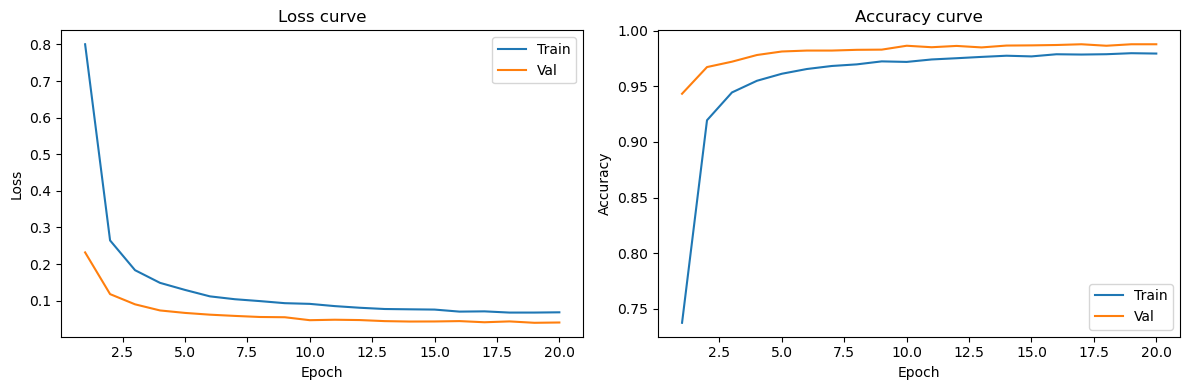

In [9]:
#@title 7 B · Training vs. Validation curves
epochs = list(range(1, len(train_losses)+1))

plt.figure(figsize=(12,4))
# Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, val_losses,   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss curve"); plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train")
plt.plot(epochs, val_accs,   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy curve"); plt.legend()

plt.tight_layout()


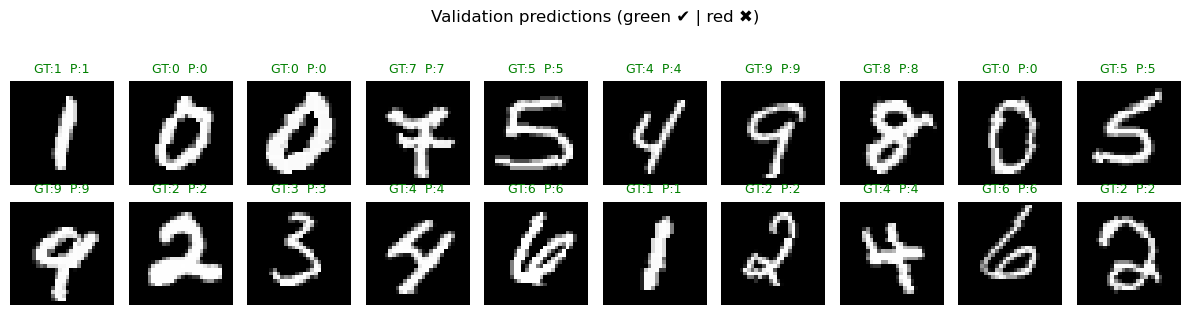

In [10]:
#@title 8 · Validation Predictions Visualisation
N_SHOW = 20
model.eval(); imgs, lbls = next(iter(val_loader))
preds = model(imgs.to(DEVICE)).argmax(1).cpu()

plt.figure(figsize=(12,3))
for i in range(N_SHOW):
    plt.subplot(2, N_SHOW//2, i+1)
    img = (imgs[i]*STD + MEAN).squeeze(); plt.imshow(img, cmap='gray'); plt.axis('off')
    col = 'green' if preds[i]==lbls[i] else 'red'
    plt.title(f"GT:{lbls[i]}  P:{preds[i]}", color=col, fontsize=9)
plt.suptitle("Validation predictions (green ✔ | red ✖)", y=1.05); plt.tight_layout()


In [11]:
# Utility · accuracy(loader)
def accuracy(net, loader):
    """
    Compute classification accuracy of `net` on all batches in `loader`.
    Assumes global `DEVICE` (cpu / cuda).
    """
    net.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = net(x).argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
    return correct / total


In [12]:
#@title 9 · Final Test-set Accuracy
test_acc = accuracy(model, test_loader)
print("Test-set Accuracy:", f"{test_acc:.4%}")


Test-set Accuracy: 99.1700%


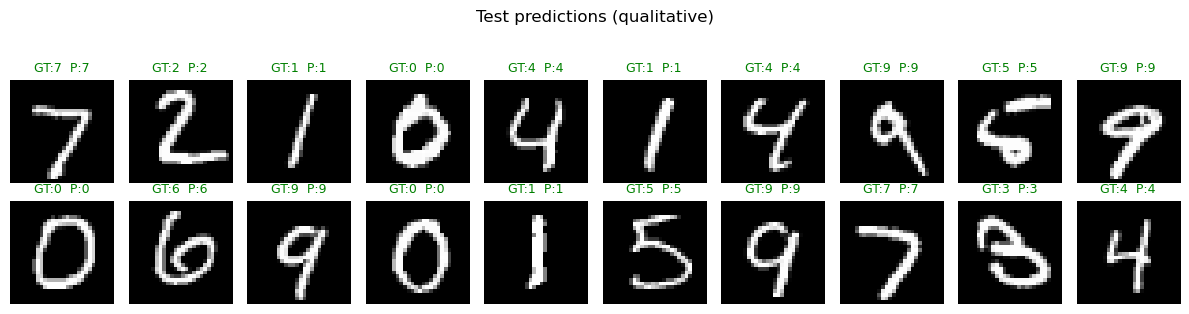

In [13]:
#@title 10 · Test-set Predictions Visualisation
N_SHOW = 20
model.eval(); t_imgs, t_lbls = next(iter(test_loader))
t_preds = model(t_imgs.to(DEVICE)).argmax(1).cpu()

plt.figure(figsize=(12,3))
for i in range(N_SHOW):
    plt.subplot(2, N_SHOW//2, i+1)
    img = (t_imgs[i]*STD + MEAN).squeeze(); plt.imshow(img, cmap='gray'); plt.axis('off')
    col = 'green' if t_preds[i]==t_lbls[i] else 'red'
    plt.title(f"GT:{t_lbls[i]}  P:{t_preds[i]}", color=col, fontsize=9)
plt.suptitle("Test predictions (qualitative)", y=1.05); plt.tight_layout()


In [14]:
# collect the first 10 correctly‐classified “4” samples
indices = []
for idx, (img, lbl) in enumerate(
        datasets.MNIST("./data", train=False, transform=test_tf)):
    if lbl == 4 and model(img.unsqueeze(0).to(DEVICE)).argmax() == 4:
        indices.append(idx)
    if len(indices) == N_FGSM_SHOW: break

orig_imgs = torch.stack([
    datasets.MNIST("./data", train=False, transform=test_tf)[i][0]
    for i in indices
]).to(DEVICE)


In [15]:
#@title 11 · Targeted FGSM (Adversarial  Attack (4 → 9)
#@title ▶️ Targeted FGSM (single-step) 4 → 9  📝 fully commented

# ---------- limits in normalised space ----------
PIX_MIN = (0.0 - MEAN) / STD       # ≈ −0.424
PIX_MAX = (1.0 - MEAN) / STD       # ≈  2.821
# -----------------------------------------------

def fgsm_to_9(x_orig,
              model,
              eps_fgsm=0.50,       # 🔧 L∞ budget for single step , 35 to 50
              target_cls=9):
    """
    One-shot targeted FGSM that turns a ‘4’ image into class ‘9’.

    Parameters
    ----------
    x_orig : (N,1,28,28) tensor  – already normalised, correctly labelled 4
    model  : trained CNN (will be set to eval)
    eps_fgsm : float           – maximum pixel change (normalised space)
    target_cls : int           – desired misclassification (9)

    Returns
    -------
    x_adv : adversarial image batch (same shape as x_orig)
    """
    model.eval()

    # --- set up target labels for CE loss ---
    target = torch.full((x_orig.size(0),),
                        target_cls,
                        dtype=torch.long,
                        device=DEVICE)

    # --- enable gradient wrt pixels ---
    x_adv = x_orig.clone().detach().to(DEVICE).requires_grad_(True)

    # --- forward pass & targeted loss ---
    loss = F.cross_entropy(model(x_adv), target)   # pull towards 9
    model.zero_grad(); loss.backward()

    # --- single FGSM update (gradient *descent* for targeted attack) ---
    x_adv = x_adv - eps_fgsm * x_adv.grad.sign()

    # --- project into valid range (optional: also clip to ε-ball) ---
    x_adv = torch.clamp(x_adv, PIX_MIN, PIX_MAX).detach()

    return x_adv


# --------------- run FGSM on the 10 “4” samples ---------------
adv_fgsm_imgs = fgsm_to_9(
    x_orig=orig_imgs,
    model=model,
    eps_fgsm=0.35)        # you can try 0.3 – 0.4 sweep

fgsm_preds = model(adv_fgsm_imgs).argmax(1).cpu().tolist()
print("FGSM predictions:", fgsm_preds)   # aim for ten 9’s

print(model(orig_imgs).argmax(1))



FGSM predictions: [9, 8, 4, 9, 4, 4, 9, 9, 4, 4]
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


In [16]:
#@title 🔍 FGSM 4 → 9  – self-check & ε-sweep

# 0. sanity: originals must be predicted 4
with torch.no_grad():
    orig_preds = model(orig_imgs).argmax(1).cpu()
print("Original preds:", orig_preds.tolist())  # should be 10 × 4

# 1. constants for normalised pixel range
PIX_MIN = (0.0 - MEAN)/STD      # ≈ −0.424
PIX_MAX = (1.0 - MEAN)/STD      # ≈  +2.821

# 2. margin-loss FGSM (slightly stronger than raw-logit or CE)
def fgsm_margin(x, eps, target_cls=9):
    x_adv = x.clone().detach().to(DEVICE).requires_grad_(True)
    logits = model(x_adv)

    tgt = logits[:, target_cls]
    max_other, _ = (logits  # biggest logit that is *not* target_cls
                    .masked_fill(
                        (torch.arange(10, device=DEVICE)==target_cls), -1e9)
                    .max(1))
    loss = -(tgt - max_other).mean()          # maximise margin for 9
    model.zero_grad(); loss.backward()

    x_adv = x_adv - eps * x_adv.grad.sign()   # targeted ⇒ descent
    x_adv = torch.clamp(x_adv, PIX_MIN, PIX_MAX).detach()
    return x_adv

# 3. ε-sweep to find the tipping-point
sweep_eps = np.arange(0.32, 0.52, 0.02)   # try 0.32 → 0.50
print("\nε-sweep (normalised L∞)   →  predictions")
for eps in sweep_eps:
    preds = model(fgsm_margin(orig_imgs, eps)).argmax(1).cpu().tolist()
    print(f"{eps:4.2f}  {preds}")


Original preds: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

ε-sweep (normalised L∞)   →  predictions
0.32  [4, 8, 4, 9, 4, 4, 4, 9, 4, 4]
0.34  [9, 8, 4, 9, 4, 4, 9, 9, 4, 4]
0.36  [9, 8, 4, 9, 4, 4, 9, 9, 4, 4]
0.38  [9, 8, 4, 9, 4, 4, 9, 9, 4, 4]
0.40  [9, 8, 4, 8, 4, 4, 9, 9, 4, 4]
0.42  [9, 8, 4, 8, 4, 4, 9, 9, 4, 4]
0.44  [9, 8, 4, 8, 4, 4, 9, 9, 4, 4]
0.46  [9, 8, 4, 8, 4, 4, 9, 9, 9, 4]
0.48  [9, 8, 4, 8, 4, 4, 9, 9, 9, 4]
0.50  [9, 8, 4, 8, 4, 4, 9, 9, 9, 4]


In [17]:
# -------- Iterative FGSM (a.k.a. I-FGSM)  4 → 9 -----------------
def ifgsm_to_9(x_orig, model,
               eps=0.50,  # total budget (same as PGD)  from 45 to 50
               k=20,      # number of sign steps  from 10 to 20
               target_cls=9):
    model.eval()
    alpha = eps / k                   # step size per mini-step
    x_adv = x_orig.clone().detach().to(DEVICE)

    target = torch.full((x_adv.size(0),),
                        target_cls, dtype=torch.long, device=DEVICE)

    for _ in range(k):
        x_adv.requires_grad_(True)
        loss = F.cross_entropy(model(x_adv), target)  # targeted CE
        model.zero_grad(); loss.backward()

        x_adv = x_adv - alpha * x_adv.grad.sign()     # targeted descent

        # project into the ε-cube after every step
        x_adv = torch.max(torch.min(x_adv, x_orig + eps),
                          x_orig - eps).detach()

    # final clamp to valid range
    x_adv = torch.clamp(x_adv, PIX_MIN, PIX_MAX)
    return x_adv

# run the attack
adv_ifgsm = ifgsm_to_9(orig_imgs, model, eps=0.50, k=20)  #from 45 to 50 and 10 to 20
print("I-FGSM preds:", model(adv_ifgsm).argmax(1).cpu().tolist())


I-FGSM preds: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [18]:
#@title ▶️ Improved Targeted Attack – Multi-step PGD (4 → 9) 📝 *heavily commented*

# --------------------------------------------------------------------
# 1. Helper: valid pixel range **after normalisation**
#    • You loaded MNIST with `transforms.Normalize((MEAN,), (STD,))`
#    • That maps raw [0,1] pixels ➜  (x - MEAN)/STD   ≈  [-0.424 , 2.821]
#    • We clamp to this range at the very end so the attack can’t
#      generate values the network has never seen.
# --------------------------------------------------------------------
PIX_MIN = (0.0 - MEAN) / STD       # ≈ –0.424
PIX_MAX = (1.0 - MEAN) / STD       # ≈  2.821

def pgd_to_9(x_orig,
             model,
             eps=0.50,            # 🔧 overall L∞ budget (max change per pixel) (0.45 t0 0.50)
             iters=150,           # 🔧 number of gradient steps  , 100 to 150
             alpha=None,          # step size (if None ➜ auto-compute)
             target_cls=9):
    """
    Targeted PGD (L∞) that pushes an MNIST **‘4’ image into class ‘9’**.

    Parameters
    ----------
    x_orig : Tensor (N,1,28,28)
        Batch of source images that are currently *correctly* classified as 4.
        **Assumed to be already normalised** with MEAN/STD.
    model  : torch.nn.Module
        Trained CNN. Will be put into `.eval()` mode inside.
    eps    : float
        Radius of allowed perturbation in L∞ norm *in the normalised space*.
    iters  : int
        How many PGD iterations (gradient steps) to run.
    alpha  : float or None
        Step size. If None, we pick α ≈ eps/iters * 1.2
        (≈110 % of the “ideal” so we fill the ε-ball quickly).
    target_cls : int
        Desired class id (9 in this task).

    Returns
    -------
    x_adv : Tensor (N,1,28,28)
        Adversarial images that the network now labels as `target_cls`
        while staying within `eps` of `x_orig` in L∞ norm.
    """

    # ------------------------------------------------------------
    # 2. Pre-flight
    # ------------------------------------------------------------
    if alpha is None:
        alpha = eps / iters * 1.2          # rule-of-thumb step size
    model.eval()                           # deactivate BN + dropout

    # clone → detach so we don't back-prop to the original tensor
    x_adv = x_orig.clone().detach().to(DEVICE)

    # create a length-N tensor filled with the target class (9)
    target_labels = torch.full((x_adv.size(0),),
                               target_cls,
                               dtype=torch.long,
                               device=DEVICE)

    # ------------------------------------------------------------
    # 3. PGD loop  (Projected-Gradient *Descent* toward the target)
    # ------------------------------------------------------------
    for _ in range(iters):

        # --- 3a. require gradients w.r.t. the image pixels ---
        x_adv.requires_grad_(True)

        # --- 3b. compute loss ---
        #     • Use cross-entropy so we *raise* the prob/logit of 9
        #       and *lower* the others at the same time.
        loss = F.cross_entropy(model(x_adv), target_labels)

        # --- 3c. gradient w.r.t. the image ---
        model.zero_grad()
        loss.backward()

        # --- 3d. update the image ---
        #     Targeted attack ⇒ we *descend* on the loss:
        #       x_adv ← x_adv - α · sign(∇ₓ  L)
        with torch.no_grad():
            x_adv -= alpha * x_adv.grad.sign()

            # --- 3e. project back into the ε-ball (L∞) around x_orig ---
            x_adv = torch.max(torch.min(x_adv, x_orig + eps),
                              x_orig - eps)

        # detach so `.grad` from previous step is dropped
        x_adv = x_adv.detach()

    # ------------------------------------------------------------
    # 4. Clamp to the valid MEAN/STD-normalised range and return
    # ------------------------------------------------------------
    x_adv = torch.clamp(x_adv, PIX_MIN, PIX_MAX)
    return x_adv


# -----------------------------------------------------------------
# 5. Build the 4 → 9 adversarial batch  (you can tweak eps/iters)
# -----------------------------------------------------------------
adv_imgs = pgd_to_9(
    x_orig=orig_imgs,
    model=model,
    eps=0.50,     # same values that worked for you (0.45 to 0.50 )
    iters=150,    # ↑ more steps → finer path within ε-ball (100 to 150)
    alpha=None)   # let the function pick α

# Check success
adv_preds = model(adv_imgs).argmax(1).cpu().tolist()
print("PGD predictions:", adv_preds)   # Expect ten 9’s
print(model(orig_imgs).argmax(1))


PGD predictions: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


Predicted label for noise = 9


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

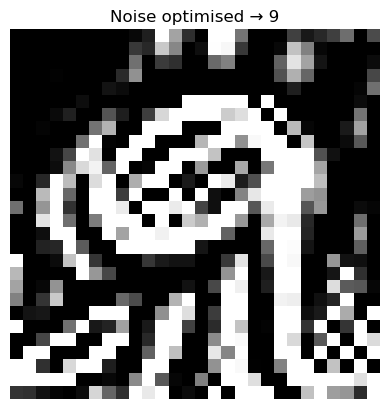

In [19]:
#@title ▶️ Noise → 9 (Logit Maximisation + L₂ regulariser)
noise = torch.rand((1,1,28,28), device=DEVICE, requires_grad=True)  # start uniform [0,1]
optim_noise = optim.Adam([noise], lr=0.12)
LAMBDA_L2   = 5e-4        # very small L2 penalty
STEPS_NOISE = 800

for step in range(STEPS_NOISE):
    optim_noise.zero_grad()
    logits = model(noise)
    loss   = -logits[0, TARGET_CLASS] + LAMBDA_L2 * torch.norm(noise)
    loss.backward()
    optim_noise.step()
    #noise.data.clamp_(0,1)
    noise.data.clamp_(PIX_MIN, PIX_MAX)


print("Predicted label for noise =", model(noise).argmax(1).item())
plt.imshow(((noise*STD)+MEAN).detach().cpu().squeeze(), cmap="gray")
plt.title("Noise optimised → 9"); plt.axis("off")


In [21]:
# --- right after your attack call ---
adv_imgs = pgd_to_9(orig_imgs, model, eps=EPS_PGD, iters=PGD_ITERS)
deltas   = adv_imgs - orig_imgs


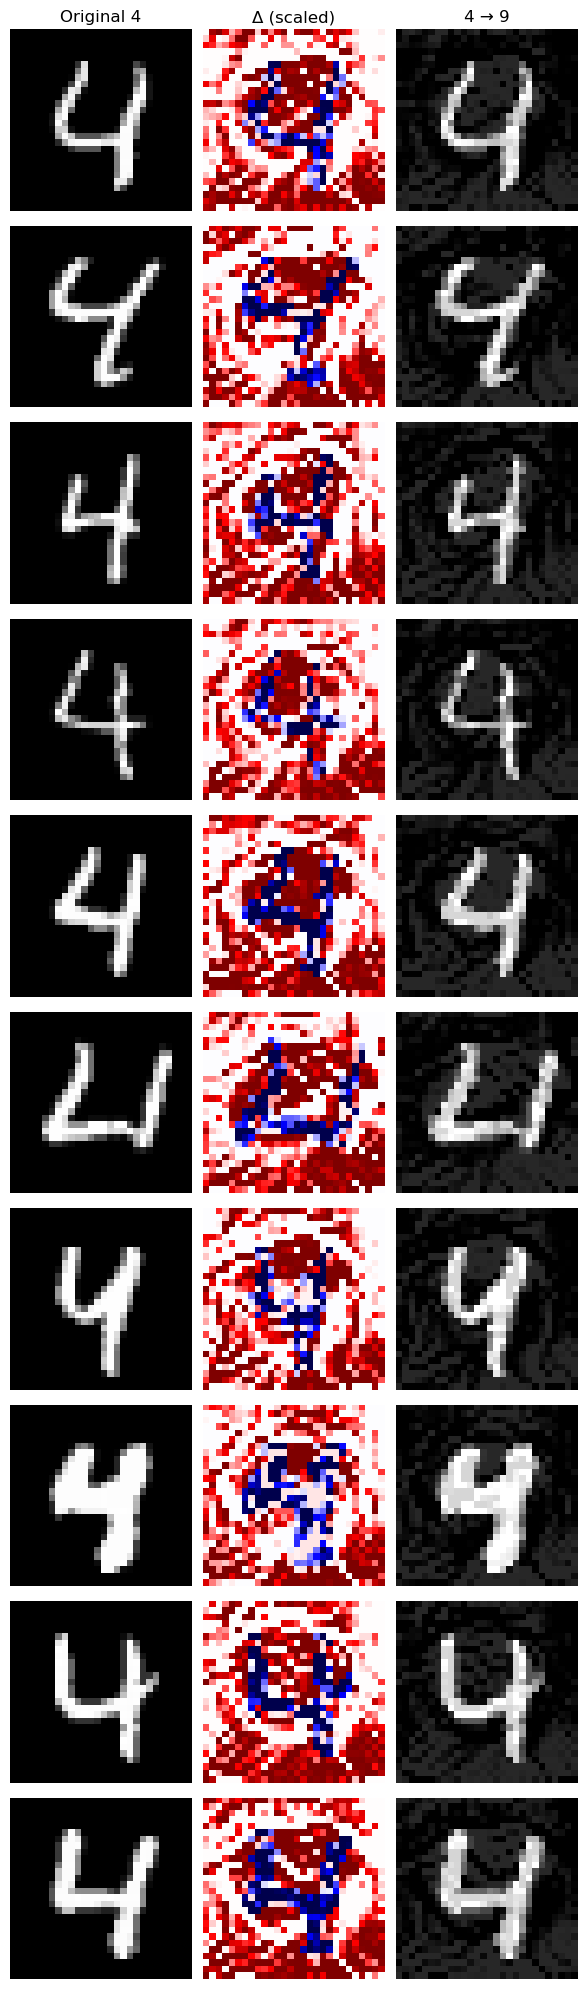

In [24]:
#@title 12 · Grid – Original | Δ | Adversarial (4 → 9)
fig, ax = plt.subplots(N_FGSM_SHOW, 3, figsize=(6,2*N_FGSM_SHOW))
for r in range(N_FGSM_SHOW):
    ax[r,0].imshow((orig_imgs[r]*STD+MEAN).squeeze().cpu(), cmap='gray'); ax[r,0].axis('off')
    ax[r,1].imshow((deltas[r]*5+0.5).squeeze().cpu(), cmap='seismic');   ax[r,1].axis('off')
    ax[r,2].imshow((adv_imgs[r]*STD+MEAN).squeeze().cpu(), cmap='gray'); ax[r,2].axis('off')
ax[0,0].set_title("Original 4"); ax[0,1].set_title("Δ (scaled)"); ax[0,2].set_title("4 → 9")
plt.tight_layout()


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

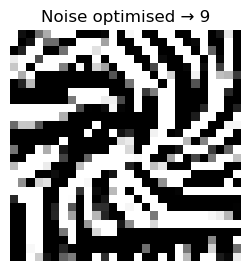

In [ ]:
#@title 13 · Optimise Pure Noise → 9 (Traget Lable)
noise = torch.randn((1,1,28,28), device=DEVICE, requires_grad=True)
target = torch.tensor([TARGET_CLASS], device=DEVICE)
opt_noise = optim.Adam([noise], lr=NOISE_LR)

for _ in range(NOISE_STEPS):
    opt_noise.zero_grad()
    loss = -criterion(model(noise), target)   # ascend towards class 9
    loss.backward(); opt_noise.step()
    noise.data.clamp_(0,1)

plt.figure(figsize=(3,3))
plt.imshow((noise.detach()*STD+MEAN).squeeze().cpu(), cmap='gray')
plt.title("Noise optimised → 9"); plt.axis('off')


# Visualization

In [ ]:
#@title 14 · Save FGSM (Adversarial) Grid (optional)
os.makedirs(GRID_SAVE_DIR, exist_ok=True)
fig.savefig(f"{GRID_SAVE_DIR}/fgsm_4_to_9_grid.png", dpi=150)
print("Saved grid to", f"{GRID_SAVE_DIR}/fgsm_4_to_9_grid.png")


Saved grid to outputs/fgsm_4_to_9_grid.png
